In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
from scipy import optimize
import warnings
warnings.filterwarnings('ignore')

In [2]:
#we will load the iris data from scikit-learn package
from sklearn.datasets import load_wine
wine = load_wine()
#check the shape of iris data
print(wine.data.shape)
A = wine.data
#check the shape of iris target
print(wine.target.shape)

#How many labels does iris data have?
C = len(np.unique(wine.target))
print(np.unique(wine.target))
print(C)
n = wine.data.shape[0] #Number of data points
d = wine.data.shape[1] #Dimension of data points

#In the following code, we create a nx1 vector of target labels
y = 1.0*np.ones([A.shape[0],])
for i in range(wine.target.shape[0]):
  if wine.target[i] != 1: # Convert class labels that are not 1 into -1
    y[i] = -1

#Create an index array
indexarr = np.arange(n) #index array
np.random.seed(10)
np.random.shuffle(indexarr) #shuffle the indices

print(indexarr) #check indexarr after shuffling
#Use the first 80% of indexarr to create the train data and the remaining 20% to create the test data
train_data = wine.data[indexarr[:int(0.8*150)]]
train_label = y[indexarr[:int(0.8*150)]]
test_data = wine.data[indexarr[int(0.8*150):]]
test_label = y[indexarr[int(0.8*150):]]

(178, 13)
(178,)
[0 1 2]
3
[ 69 103  20 116  56  97 117  39 172  10  19  66  55  61 102  59  83  78
 110 163   1 160  47  49  67 136  68 133  60  76 171 170  70 168 124  26
  95  91  24 109 121  21 176  63  58  99 144  81  87  43 150 120 138  35
 174  82   2 114 153  38  52 142 177 146 148 101  80  72 145  98  41  32
 105  48  25  53  90 149  51  14 162  29   3  23 131 166  37 167 165  45
 111 134  42  79 143 155 119 147  12 127  22  85   6 106 112 135 132 104
  34 152 108  50 169 130 129   4   5  44 128  96  84 154  28  75   7  46
  17  11 158  71 118 137 175  74  94 151  93  18  27  36  57  31  65 140
  89  30  86  92 141 126  13  77 159 161  33  62 122 107  88  54 139 100
  16 115 164  40   0  73   8 173 157 156 123 113  64  15 125   9]


In [3]:
def predict(w,x):
  return np.sign(np.dot(w,x))

def compute_accuracy(data,labels,model_w):
  count = 0
  for i in range(data.shape[0]):
    z = predict(model_w,data[i])
    y = labels[i]
    if z==y:
      count = count+1

  return 100*(count/data.shape[0])

$$ \large{f_i(w) = \frac{\lambda}{2n} \sum_{j=1}^{d}w_j^2 + \frac{1}{n} L(y_i,w^Tx_i)} $$ \\

And we will solve the following costrained optimization problem $$min \ \sum_if_i(w) \\
s.t. \ w \in C$$

In [4]:
def compute_loss_h(w,x,y):
  return max(0, 1-y*np.dot(w,x))

In [5]:
def compute_objfnval(data,labels,model_w,lamda):
  fun_value = 0
  a = 0.5*lamda*((np.linalg.norm(model_w))**2)
  n = len(labels)
  for data_pt, label in zip(data, labels):
    b = compute_loss_h(model_w, data_pt, label)
    fun_value = fun_value + b

  return a + (fun_value/n)

In [6]:
def compute_grad_loss_h(x,y,model_w,lamda):
  n = model_w.shape[0]
  condition = 1 - y*np.dot(model_w, x)
  if condition < 0:
    grad = lamda*model_w
  else:
    grad = np.subtract(lamda*model_w, y*x)
    
  return np.multiply(1/n,grad)

In [7]:
def compute_orthogonal_projection(z):
  length = len(z)
  def f(u):
    L2_norm_sq = 0
    #length = len(z)
    for i in range(length):
      L2_norm_sq = L2_norm_sq + (u[i]-z[i])**2
    return np.sqrt(L2_norm_sq)

  #result = optimize.minimize_scalar(f)
  result = optimize.minimize(f, np.ones(length), method="CG")
  return result.x

In [8]:
def compute_orthogonal_projection(z):
  length = len(z)
  argmin = np.ones(length)
  for i in range(length):
    if abs(z[i]) <= 1:
      argmin[i] = z[i]
    elif z[i] < -1:
      argmin[i] = -1
    else:
      argmin[i] = 1
  return argmin

In [9]:
def compute_orthogonal_projection(z, lamda):
  Len = len(z)
  u = np.ones(Len)
  sum = np.sum(abs(z[i]) for i in range(Len))
  if sum <= 1:
    u = z
  if sum > 1:
    for i in range(Len):
      u[i] = u[i]/sum
  return u

In [10]:
def OPT1(data, label, lamda, num_epochs):
  t = 1.0
  obj_values = []
  train_accuracy = []
  test_accuracy = []
  #initialize w
  w = np.random.randn(data.shape[1])
  arr = np.arange(data.shape[0])
  for epoch in range(num_epochs):
    np.random.shuffle(arr) #shuffle every epoch
    for i in np.nditer(arr): #Pass through the data points
      step = 1/t
      # Update w using w <- w - step * g_i (w)
      w = compute_orthogonal_projection(np.subtract(w, np.multiply(step, compute_grad_loss_h(data[i],label[i],w,lamda))), lamda)
      t = t+1
      if t>1e4:
        t = 1
    obj_values.append(compute_objfnval(data,label,w,lamda))
    train_accuracy.append(compute_accuracy(data,label,w))
    global test_data
    global test_label
    test_accuracy.append(compute_accuracy(test_data,test_label,w))
  return w,obj_values,train_accuracy,test_accuracy

In [11]:
lamda_list = [1e-3,1e-2,0.1,1.0,10.0]
num_epochs = 500

**Que 6 (a),(b),(C),(d)**

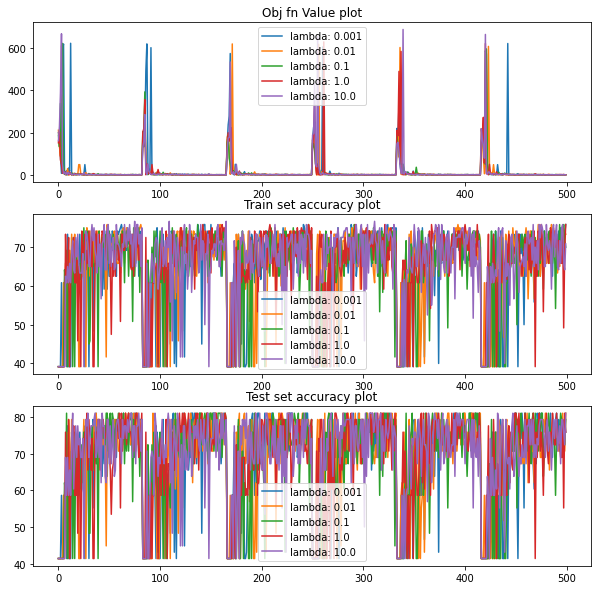

In [12]:
final_train_acc = []
final_test_acc = []

fig, axs = plt.subplots(3, figsize=(10,10))
for l in lamda_list:
  w, fn, train_acc, test_acc = OPT1(train_data, train_label, l, num_epochs)
  axs[0].plot(list(range(num_epochs)),fn,label = 'lambda: '+str(l))
  axs[1].plot(list(range(num_epochs)),train_acc,label = 'lambda: '+str(l))
  axs[2].plot(list(range(num_epochs)),test_acc,label = 'lambda: '+str(l))
  final_train_acc.append(compute_accuracy(train_data,train_label,w))
  final_test_acc.append(compute_accuracy(test_data,test_label,w))
axs[0].legend()
axs[1].legend()
axs[2].legend()
axs[0].set_title('Obj fn Value plot')
axs[1].set_title('Train set accuracy plot')
axs[2].set_title('Test set accuracy plot')
fig.show()

In [13]:
table = []
for i in range(len(lamda_list)):
  table.append( [ lamda_list[i], final_train_acc[i], final_test_acc[i] ] )
print(tabulate(table, headers=["Lambda", "Final Train Set Accuracy", "Final test Set Accuracy"]))

  Lambda    Final Train Set Accuracy    Final test Set Accuracy
--------  --------------------------  -------------------------
   0.001                     75.8333                    75.8621
   0.01                      73.3333                    81.0345
   0.1                       70                         79.3103
   1                         75.8333                    75.8621
  10                         70.8333                    81.0345


**Observations**

We are getting max accuracy for lambda=0.01 and 10.
The change in obj fn value and accuracy is very less at each epoch. But there are steep rise in obj fn value at some epochs.



In [14]:
def compute_loss_l(w,x,y):
  return np.log(1+np.exp(-y*np.dot(w,x)))

In [15]:
def compute_objfnval2(data,labels,model_w,lamda):
  fun_value = 0
  a = 0.5*lamda*((np.linalg.norm(model_w))**2)
  n = len(labels)
  for data_pt, label in zip(data, labels):
    b = compute_loss_l(model_w, data_pt, label)
    fun_value = fun_value + b

  return a + (fun_value/n)

In [16]:
def compute_grad_loss_l(data, label,w ,lamda):
  dummy1 =  np.multiply(np.multiply(label, np.transpose(data)), np.exp(-np.dot(label, np.dot(w, np.transpose(data)))))
  dummy2 = np.add(1, np.exp(-np.dot(label, np.dot(w, np.transpose(data)))))
  
  return np.subtract(np.multiply(lamda, w),dummy1/dummy2)/data.shape[0]

In [17]:
def compute_loss_sh(w,x,y):
  return (compute_loss_h(w,x,y))**2

In [18]:
def compute_loss_sh(w,x,y):
  return (max(0,1-y*np.dot(w,x)))**2

In [19]:
def compute_objfnval3(data,labels,model_w,lamda):
  fun_value = 0.0
  a = 0.5*lamda*((np.linalg.norm(model_w))**2)
  n = len(labels)
  for data_pt, label in zip(data, labels):
    b = compute_loss_sh(model_w, data_pt, label)
    fun_value = fun_value + b

  return a + (fun_value/n)

In [20]:
def compute_objfnval3(data,labels,w,lamda):
  return np.add(np.multiply(lamda/2 , np.linalg.norm(w)**2), sum(compute_loss_sh(w,data[i],labels[i]) for i in range(data.shape[0]))/data.shape[0])

In [21]:
def compute_grad_loss_sh(x,y,w,lamda):
  grad = 0
  if np.dot(y,np.dot(w,np.transpose(x))) >= 1:
    grad = np.multiply(lamda, w)/x.shape[0]
  else:
    dummy = np.multiply(np.multiply(2, np.subtract(1,np.dot(y,np.dot(w,np.transpose(x))))),np.multiply(y,np.transpose(x)))
    grad = np.subtract(np.multiply(lamda,w),dummy)/x.shape[0]
  return grad

In [22]:
def OPT2(data, label, lamda, num_epochs):
  t = 1.0
  obj_values = []
  train_accuracy = []
  test_accuracy = []
  #initialize w
  w = np.random.randn(data.shape[1])
  arr = np.arange(data.shape[0])
  for epoch in range(num_epochs):
    np.random.shuffle(arr) #shuffle every epoch
    for i in np.nditer(arr): #Pass through the data points
      step = 1/t
      # Update w using w <- w - step * g_i (w)
      w = compute_orthogonal_projection(np.subtract(w, np.multiply(step, compute_grad_loss_l(data[i],label[i],w,lamda))),lamda)
      t = t+1
      if t>1e4:
        t = 1
    obj_values.append(compute_objfnval2(data,label,w,lamda))
    train_accuracy.append(compute_accuracy(data,label,w))
    global test_data
    global test_label
    test_accuracy.append(compute_accuracy(test_data,test_label,w))
  return w,obj_values,train_accuracy,test_accuracy

**Que 7**

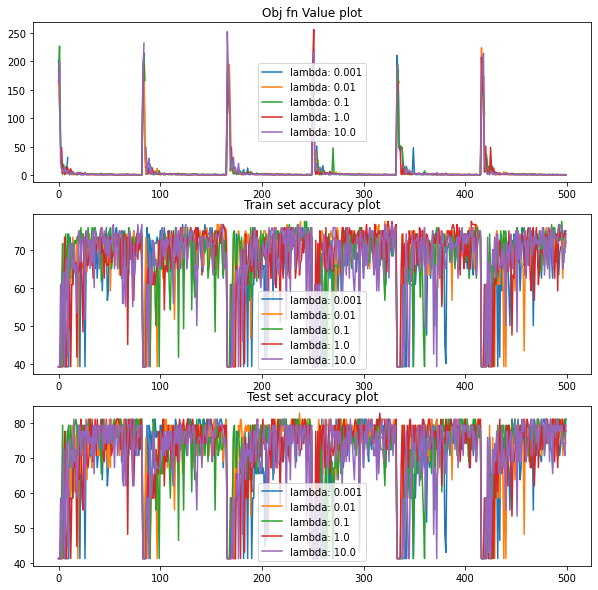

In [23]:
final_train_acc = []
final_test_acc = []

fig, axs = plt.subplots(3, figsize=(10,10))
for l in lamda_list:
  w, fn, train_acc, test_acc = OPT2(train_data, train_label, l, num_epochs)
  axs[0].plot(list(range(num_epochs)),fn,label = 'lambda: '+str(l))
  axs[1].plot(list(range(num_epochs)),train_acc,label = 'lambda: '+str(l))
  axs[2].plot(list(range(num_epochs)),test_acc,label = 'lambda: '+str(l))
  final_train_acc.append(compute_accuracy(train_data,train_label,w))
  final_test_acc.append(compute_accuracy(test_data,test_label,w))
axs[0].legend()
axs[1].legend()
axs[2].legend()
axs[0].set_title('Obj fn Value plot')
axs[1].set_title('Train set accuracy plot')
axs[2].set_title('Test set accuracy plot')
fig.show()

In [24]:
table = []
for i in range(len(lamda_list)):
  table.append( [ lamda_list[i], final_train_acc[i], final_test_acc[i] ] )
print(tabulate(table, headers=["Lambda", "Final Train Set Accuracy", "Final test Set Accuracy"]))

  Lambda    Final Train Set Accuracy    Final test Set Accuracy
--------  --------------------------  -------------------------
   0.001                     71.6667                    81.0345
   0.01                      70.8333                    74.1379
   0.1                       74.1667                    81.0345
   1                         75                         77.5862
  10                         74.1667                    79.3103


In [25]:
def OPT3(data, label, lamda, num_epochs):
  t = 1.0
  obj_values = []
  train_accuracy = []
  test_accuracy = []
  #initialize w
  w = np.random.randn(data.shape[1])
  arr = np.arange(data.shape[0])
  for epoch in range(num_epochs):
    np.random.shuffle(arr) #shuffle every epoch
    for i in np.nditer(arr): #Pass through the data points
      step = 1/t
      # Update w using w <- w - step * g_i (w)
      w = compute_orthogonal_projection(np.subtract(w, np.multiply(step, compute_grad_loss_sh(data[i],label[i],w,lamda))), lamda)
      t = t+1
      if t>1e4:
        t = 1
    obj_values.append(compute_objfnval3(data,label,w,lamda))
    train_accuracy.append(compute_accuracy(data,label,w))
    global test_data
    global test_label
    test_accuracy.append(compute_accuracy(test_data,test_label,w))
  return w,obj_values,train_accuracy,test_accuracy

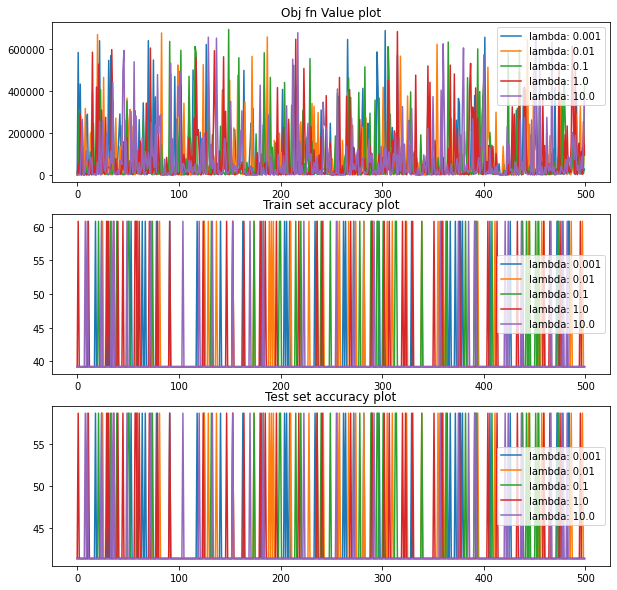

In [26]:
final_train_acc = []
final_test_acc = []

fig, axs = plt.subplots(3, figsize=(10,10))
for l in lamda_list:
  w, fn, train_acc, test_acc = OPT3(train_data, train_label, l, num_epochs)
  axs[0].plot(list(range(num_epochs)),fn,label = 'lambda: '+str(l))
  axs[1].plot(list(range(num_epochs)),train_acc,label = 'lambda: '+str(l))
  axs[2].plot(list(range(num_epochs)),test_acc,label = 'lambda: '+str(l))
  final_train_acc.append(compute_accuracy(train_data,train_label,w))
  final_test_acc.append(compute_accuracy(test_data,test_label,w))
axs[0].legend()
axs[1].legend()
axs[2].legend()
axs[0].set_title('Obj fn Value plot')
axs[1].set_title('Train set accuracy plot')
axs[2].set_title('Test set accuracy plot')
fig.show()

In [27]:
table = []
for i in range(len(lamda_list)):
  table.append( [ lamda_list[i], final_train_acc[i], final_test_acc[i] ] )
print(tabulate(table, headers=["Lambda", "Final Train Set Accuracy", "Final test Set Accuracy"]))

  Lambda    Final Train Set Accuracy    Final test Set Accuracy
--------  --------------------------  -------------------------
   0.001                     39.1667                    41.3793
   0.01                      39.1667                    41.3793
   0.1                       39.1667                    41.3793
   1                         39.1667                    41.3793
  10                         39.1667                    41.3793


**Observations**

For squared hinge loss we are getting very high objective function value, whch is very weired as we are minimizing the loss.
We are getting almost same accuracies for hinnge loss and logistic loss and very low accuracy for squared hinge loss.